# Exemplo de programa para varredura em frequência

## 1.Inicialização

Na celula são inicializadas...

In [1]:
'''importa as bibliotecas necessárias'''
import pylef   # importar pylef 
import visa    # importar a bilioteca pyVISA para lidar com virtualização de instrumentos
import matplotlib.pyplot as plt  # importar a bilioteca pyplot para fazer gráficos
import numpy as np   # importar a biblioteca Numpy para lidar com matrizes
import time          # importar a bilioteca para funções temporais
import pandas as pd   # importa bilioteca pandas para  lidar com processamento de dados
import os            # biblioteca para lidar com diretórios
#import sys 
#bibliotecas para atualizacoa de grafico
from IPython.core.display import clear_output
from IPython.display import display, Javascript
# próxima linha faz plotar o gráfico dentro do notebook
%matplotlib inline   

 <span style="color:red">Você dever ...</span>

In [2]:
# imprime os recursos para ter certeza que os instrumentos estão conectados
visa.ResourceManager().list_resources()

('USB0::0xF4ED::0xEE3A::388C14164::INSTR',
 'USB0::0x0699::0x03B0::C011175::INSTR',
 'ASRL1::INSTR')

In [3]:
'''Inicializa classes para controlar instrumentos'''
func_gen = pylef.BK4052()          # definição do gerador de funções
scope = pylef.TektronixTBS1062()   # definição do osciloscópio

Gerador de Funções conectado! Id = *IDN BK Precision,4052,388C14164,1.01.01.31R1,02-00-00-22-26
Osciloscópio conectado! Id = TEKTRONIX,TBS 1062,C011175,CF:91.1CT FV:v26.01


In [45]:
%matplotlib inline

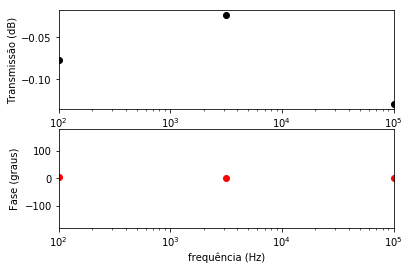

Fim! Tempo total de medida=8.83406 s


In [9]:
Vpp =2.0      # Tensão pico-a-pico na saida do gerador
Nfreq = 3   # frequências número de pontos
freq0 = 100   # frequências inicial
freq1 = 1e5  # frequências final
figure,freq,Vpp1,Vpp2,phase=sweep_frequency(freq0, freq1, Nfreq, spacing='log', average=16)

In [8]:
'''
--------------------------
Funções para graficar ao vivo e adquirir dados
NÃO ALTERE NADA NESTA CÉLULA
--------------------------
'''
#***********************************************
#***********************************************
def plot_bode(freq,phase,T,T_dB,spacing='log'):
    '''
    Função para graficar transmistância e fase
    ===============
    Uso simples:
    >>> figure = plot_bode(freq,phase,T,T_dB,spacing)
    entrada:
    --------
    freq: vetor de frequências (lista ou numpy.array)
    phase: vetor de fases (lista ou numpy.array)
    T: vetor de transmitância linear (lista ou numpy.array)
    T_dB: vetor de transmitância em decibéis (lista ou numpy.array)
    spacing (opcional): 'linear' (espaçamento linear) ou 'log' (espaçamento logarítmico); por padrao o espaçamento é linear
    --------
    saída:
    figure:objeto gráfico do Matplotlib
    '''
    #Identificando se é linear ou log
    npt = len(T_dB)
    fig, ax = plt.subplots(2, sharex=True)
    if spacing=='log':
        y=T_dB
        y_label='Transmissão (dB)'
    elif spacing=='linear':
        y=T
        y_label='Transmissão'
    #-----------------------------------
    #TRANSMISSION PLOT
    #-----------------------------------
    ax[0] = plt.subplot(211)  # define um eixo
    ax[0].plot(freq[0:npt], y[0:npt], 'ko')   # plota a transmissão  
    ax[0].set_xscale(spacing)   # seta a escala de x para logaritmica
    # Por que não usamos escala log no eixo y também?
    #ax[0].set_xlabel('frequência (Hz)')   # seta escala do eixo x
    ax[0].set_ylabel(y_label)   # seta escala do eixo y
    plt.xlim((freq.min(),freq.max()))
    #-----------------------------------
    #PHASE PLOT
    #-----------------------------------
    ax[1] = plt.subplot(212)  # define um eixo
    ax[1].plot(freq[0:npt], phase[0:npt], 'ro')   # plota a transmissão  
    ax[1].set_xscale(spacing)   # seta a escala de x para logaritmica
    # Por que não usamos escala log no eixo y também?
    ax[1].set_xlabel('frequência (Hz)')   # seta escala do eixo x
    ax[1].set_ylabel('Fase (graus)')   # seta escala do eixo y
    plt.xlim((freq.min(),freq.max()))
    plt.ylim((-180,180))
    #------------------------------------
    clear_output(True)
    display(fig)
    plt.close() 
    return fig
#***********************************************
#***********************************************
def sweep_frequency(freq0, freq1, Nfreq, spacing = 'linear', average = 4):
    '''
    Função para realizar um sweep e fazer gráfico
    ===============
    Uso simples:
    >>> figure, freq, vpp1, vpp2, phase = sweep_frequency(freq0,freq1,Nfreq,spacing = 'linear')
    figure: figura
    freq0: frequência inicial (Hz)
    freq1: frequencia final (Hz)
    Nfreq: número de pontos no vetor de frequências
    spacing (opcional): 'linear' (espaçamento linear) ou 'log' (espaçamento logarítmico)
    average: número de médias a serem realizadas
    '''
    display(Javascript("""
    require(
    ["base/js/dialog"], 
    function(dialog) {
        dialog.modal({
            title: 'Hello world',
            body: 'Hi, lorem ipsum and such',
            buttons: {
                'kthxbye': {}
                }
            });
        }
    );"""))
    start=time.time() # conta tempo
    #------------------
    #constroi vetor de frequencias
    #------------------
    if spacing == 'linear':
        freq = np.linspace(freq0, freq1, Nfreq, endpoint = True)  # varredura logaritmica
    elif spacing == 'log':
        freq = np.logspace(np.log10(freq0), np.log10(freq1), Nfreq, endpoint = True)  # varredura logaritmica
    else:
        raise ValueError('O espaçamento entre os pontos deve ser linear ou log')
    #### Aquisição de dados!! ####
    scope.set_average_number(average)  # ajusta o número de médias
    scope.set_average()    # turn average ON
    #-----------------
    Vpp1, Vpp2 = [], []    # listas para guardar as variáveis
    #phase1, phase2 = [], []    # listas para guardar as variáveis
    phase = []   # listas para guardar as variáveis
    ### aquisição de dados no gerador com varredura de frequência
    scope.write('MEASUREment:MEAS1:TYPE NONE')
    scope.write('MEASUREment:MEAS2:TYPE NONE')
    scope.write('MEASUREment:MEAS3:TYPE NONE')
    scope.write('MEASUREment:MEAS4:TYPE NONE')
    scope.write('MEASUREment:MEAS5:TYPE NONE')
    for m, freqP in enumerate(list(freq)):  # loop de aquisição
        #print('Medida ' + str(m + 1))
        print('Frequencia atual={:2g} Hz'.format(freq[m]))
        start=time.time()
        ### ajuste dos instrumentos
        func_gen.ch1.set_frequency(freqP)   # muda a frequência
        periodP = 1./freqP   # período da onda
        scope.set_horizontal_scale(periodP/4.)  # escala horizontal = 1/4 período (2.5 oscilações em tela)
        scope.ch1.set_smart_scale()    #  rescala o canal 1
        scope.ch2.set_smart_scale()    #  rescala o canal 2
        ### aquisição de dados
        Vpp1.append(scope.ch1.measure.Vpp()) # acumula a medida do Vpp no canal 1
        phase.append(-scope.ch1.measure.phase()) # acumula a medida da fase no canal 1    
        Vpp2.append(scope.ch2.measure.Vpp())  # acumula a medida do Vpp no canal 2
        #---------plotting stuff-------
        T = (np.array(Vpp2)/np.array(Vpp1))**2   # cálculo da transmissão 
        T_dB = 10*np.log10(T)  # transmissão em dB
        # plota o diagrama de bode para a transmissão e exporta em png
        fig = plot_bode(freq,phase,T,T_dB,spacing)
        #-------
    print('Fim! Tempo total de medida={:2g} s'.format(time.time()-start))
    Vpp1 = np.array(Vpp1)  # convete a lista em array
    Vpp2 = np.array(Vpp2)  # convete a lista em array
    phase = np.array(phase)  # convete a lista em array
    return fig, freq, Vpp1, Vpp2, phase

<span style='color:red'>Veja como a função de varredura funciona:</span>

In [ ]:
?sweep_frequency

In [19]:
  print('Fim! Tempo total de medida={:2g} s'.format(203.434))

Fim! Tempo total de medida=203.434 s


In [34]:
scope.ch1.measure.phase()

-2.877122879

## 2. Executando a varredura

In [23]:
Vpp = 1.0      # Tensão pico-a-pico na saida do gerador
Nfreq = 10    # frequências número de pontos
freq0 = 100   # frequências inicial
freq1 = 1e5  # frequências final

In [7]:
#---------------------------------------
# Pré-aquisição
#---------------------------------------
# mude a onda para uma senóide!
func_gen.ch1.set_function('sine')
# ajuste o trigger externo
scope.trigger.set_source('ch1')  # ajusta o trigger para externo no osciloscópio
## ajusta média nos canais
scope.set_average_number(4)  # ajusta o número de médias
scope.set_average()    # turn average ON
#scope.set_sample()       # turn average OFF
#---------------------------------------
## parâmetros inicias do gerador
func_gen.ch1.set_frequency(freq0) 
func_gen.ch1.set_Vpp(Vpp)
func_gen.ch1.set_offset(0.0)
func_gen.ch1.set_phase(0.0)
## tenha certeza que o gerador está ligado e que o canal 1 está na escala certa
func_gen.ch1.turn_on()   # liga o canal 1
#---------------------------------------
scope.set_horizontal_scale((1/freq0)/4.)  # escala horizontal = 1/4 período (2.5 oscilações em tela)
scope.ch1.set_smart_scale()  # rescala o canal 1
scope.ch2.set_smart_scale()  # rescala o canal 2

ValueError: O canal CH2 está desligado!

### <span style="color:red">Importante</span>

* Antes de executar a próxima linha de código, verifique se o gerador e o osciloscópio estão nas configurações esperadas. 

* Tenha certeza que você entendeu o que cada um dos comandos acima está fazendo.

* Identifique quais botões do osciloscópio/gerador realizam as funções similares às executadas acima

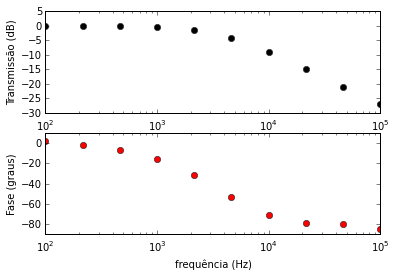

tempo de medida (s)=  5.6930460929870605


In [25]:
Vpp =2.0      # Tensão pico-a-pico na saida do gerador
Nfreq = 10    # frequências número de pontos
freq0 = 100   # frequências inicial
freq1 = 1e5  # frequências final
figure,freq,Vpp1,Vpp2,phase=sweep_frequency(freq0, freq1, Nfreq, spacing='log')

## 3. Organizando os dados em ```Dataframe``` do Pandas

In [26]:
#calculando a transmitância
T=Vpp2/Vpp1   # cálculo da transmissão 
T_dB = 20*np.log10(T)  # transmissão em dB
#gerando tabelas
dados = pd.DataFrame()   # inicializa um dataframe do pandas
dados['Vpp1 (V)'], dados['Vpp2 (V)'] = Vpp1, Vpp2
dados['fase (Ch1-Ch2) (graus)']= phase
dados['frequencia (Hz)'], dados['T'] , dados['T_dB'] = freq, T, T_dB 

Verificando o resultado, a tabela resultante do comando abaixo é o que você obterá no seu arquivo! 

In [34]:
dados.head(3) # mostra as três primeiras linhas...

,Vpp1 (V),Vpp2 (V),fase (Ch1-Ch2) (graus),frequencia (Hz),T,T_dB
0,10.131415,10.221927,1.800000,100.000000,1.008934,0.077253
1,10.131415,10.127982,-1.860465,215.443469,0.999661,-0.002944
2,10.068876,10.096416,-6.679036,464.158883,1.002735,0.023724


### Salvando arquivo

In [35]:
## parametros de varredura
PATH = 'meu_experimento/'     # pasta onde salvar todos os arquivos
## Não coloque .dat aqui, pois as extensões são adicionadas automaticamente
nome_arquivo = 'exp_1a'    # nome prefixo dos arquivos  
##--------------------------------------------------------
#Cria a pasta no computador, veja a variável PATH
try: 
    os.makedirs(PATH)     # make new directory unless it already exists
except OSError:
    if not os.path.isdir(PATH):
        raise
#qual pasta estou?
print('pasta atual:',os.getcwd())        
time_suf = time.strftime('_%H_%M_%S', time.localtime(time.time())) 
nome_fig = PATH + nome_arquivo + '_bode' + time_suf + '.png'
nome_csv = PATH + nome_arquivo + '_dados' + time_suf + '.dat'
#Salvando
figure.savefig(nome_fig, bbox_inches = 'tight')  # salva figura na pasta de trabalho
dados.to_csv(nome_csv, sep = '\t')   # \t significa que o separador é uma tabulação, index=False remove os indices da coluna

pasta atual: /Users/gsw/Dropbox/Disciplinas/f429/2017_1s/python


## 4. Encerrando comunicação com os instrumentos

In [36]:
''' encerra a comunicação osciloscópio e o gerador de funções '''
scope.close()
func_gen.close()
'''APÓS ESTE COMANDO É NECESSÁRIO ABRIR NOVAMENTE CASO QUEIRA COMUNICAR DE NOVO
'''